In [1]:
n = 5
edge_list = [(0, 1, 1.0), (0, 2, 1.0), (0, 4, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0)]

In [5]:
from qiskit.quantum_info import SparsePauliOp
def build_hamiltonian(n, edge_list):
    pauli_list = []
    for (i, j, weight) in edge_list:
        pauli_list.append(["I"] * n)
        pauli_list[-1][i] = "Z"
        pauli_list[-1][j] = "Z"
        pauli_list[-1] = ("".join(pauli_list[-1])[::-1], weight)
    return SparsePauliOp.from_list(pauli_list)

In [6]:
print("Cost Function Hamiltonian:", build_hamiltonian(n, edge_list))

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


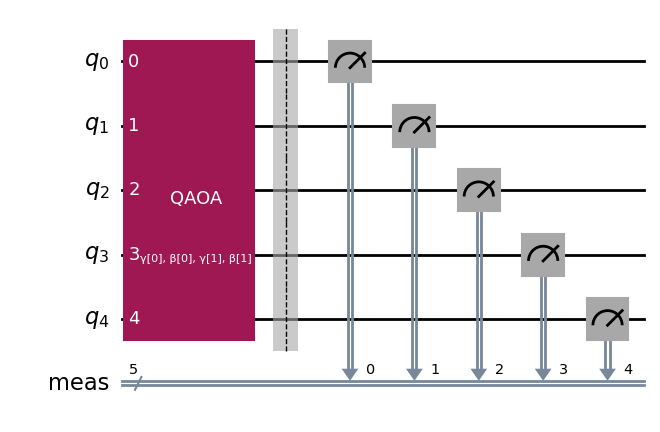

In [7]:
from qiskit.circuit.library import QAOAAnsatz

circuit = QAOAAnsatz(cost_operator=build_hamiltonian(n, edge_list), reps=2)
circuit.measure_all()

circuit.draw('mpl')

In [8]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1])])

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


# QiskitRuntimeService.save_account(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>", overwrite=True, set_as_default=True)
service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.least_busy(min_num_qubits=127)
print(backend)

# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=backend)

candidate_circuit = pm.run(circuit)
candidate_circuit.draw('mpl', fold=False, idle_wires=False)